In [559]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from scipy import sparse
from pathlib import Path
import scanpy as sc
import squidpy as sq
import copy
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

import csv
from itertools import combinations, permutations

In [195]:
samples = [151507, 151508, 151669, 151670, 151673, 151674]
['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'WM']

palette = {
                    
    '1': "#ED247F", 1: "#ED247F", 'L1': "#ED247F",
    '2': '#397CBA', 2: '#397CBA', 'L2': '#397CBA',
    '3': '#49AB4F', 3: '#49AB4F', 'L3': '#49AB4F',
    '4': '#9A4D9E', 4: '#9A4D9E', 'L4': '#9A4D9E',
    '5': '#F9D606', 5: '#F9D606', 'L5': '#F9D606',
    '6': '#F47C20', 6: '#F47C20', 'L6': '#F47C20',
    '7': '#171717', 7: '#171717', 'WM': '#171717',
    '8': '#676767', 8: '#676767', 
}

In [36]:
# col_metadata = pd.read_csv(r'../data/column_metadata.csv', index_col=0)
# row_metadata = pd.read_csv(r'../data/row_metadata.csv', index_col=0)
# filtfiles = [x for x in Path(r'..\data').glob('*filt*.h5')]
# filtfiles = [x for x in filtfiles if any(sample for sample in samples if str(sample) in str(x))]

# Load datasets
1. Raw, non-normalized counts
2. normalized_total (scanpy)
3. Dino
4. SCT
5. Cell count (drop zeros, or set zero to 1?)
6. Square Root cell count

In [199]:
def load_sparse_mat(filtered_filename, sample_number):
    with h5py.File(filtered_filename, 'r') as f:
        data = np.array(f['matrix']['data'])
        filtered_barcodes = np.array(f['matrix']['barcodes']).astype('U13')  # b'AAACAAGTATCTCCCA-1'  4992 columns
        _id = np.array(f['matrix']['features']['id']).astype('U13')   #  b'ENSG00000275063' 33538 rows
        name = np.array(f['matrix']['features']['name']).astype('U13')   # Gene name b'AL627309.3' 33538 rows
        indices = np.array(f['matrix']['indices'])
        indptr = np.array(f['matrix']['indptr'])
        shape = np.array(f['matrix']['shape'])
        
    barcodes = pd.DataFrame(filtered_barcodes)
    barcodes['in_filtered'] = barcodes[0].isin(filtered_barcodes).astype('int')
    m = sparse.csr_matrix((data, indices, indptr), shape=(shape[1], shape[0]))
    index = [barcodes[0].astype('str').to_list(), 
             [str(sample_number)]*len(barcodes)]
    columns = [name, _id]
    return m.toarray()

def load_data():
    col_metadata = pd.read_csv(r'../data/column_metadata.csv', index_col=0)
    row_metadata = pd.read_csv(r'../data/row_metadata.csv', index_col=0)
    filtfiles = [x for x in Path(r'..\data').glob('*filt*.h5')]
    filtfiles = [file for file in filtfiles if any(sample for sample in samples if str(sample) in str(file))]
    
    dfs = []
    for filtered_file in filtfiles:
        sample_number = filtered_file.stem.split('_')[0]
        df = load_sparse_mat(filtered_filename=filtered_file, 
                             sample_number=sample_number)
        dfs.append(df)
    cdf = np.concatenate(dfs)
    adata_master = sc.AnnData(
        X=cdf,   
        obs=col_metadata.loc[col_metadata.sample_name.isin(samples)],     
        var=row_metadata)  
    del cdf
    del dfs
    return adata_master
adata_master = load_data()

# Filter genes that had below a certain count (gene list borrowed from output from the R script)
high_count_genes = []
with open('../data/Dino_norms/151507_Dino_norm_sparse.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for line in reader:
        high_count_genes.append(line[0])
        
adata_master = adata_master[:, high_count_genes]
adata_master

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


View of AnnData object with n_obs × n_vars = 23081 × 2831
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialDE

In [243]:
# nt = Normalized Total method of normalization
nt = copy.copy(adata_master)

## Make a loop that performs the normalization, log1p, HVG, then the clusterings: PCA, neighbors, UMAP, Leiden on each sample in the normalization method

In [ ]:
nts = {}

In [404]:
for sample in samples:
    print(sample)
    subset = nt[nt.obs['sample_name'] == sample]
    sc.pp.normalize_total(subset, exclude_highly_expressed=True, inplace=True)
    sc.pp.log1p(subset)
    sc.pp.highly_variable_genes(adata=subset, n_top_genes=200, flavor='seurat')
    print('pre neighbors')
    sc.pp.neighbors(subset, n_neighbors=50)
    print('post neighbors')
    sc.pp.pca(subset)
    n_clusters = len(subset.obs['spatialLIBD'].unique()) - 1  # SUBTRACT 1 TO REMOVE THE NaN SPOTS
    kmeans_labels = KMeans(n_clusters=n_clusters, random_state=1).fit(subset.obsm['X_pca']).predict(subset.obsm['X_pca'])
    
    subset.obs['kmeans'] = kmeans_labels
    
    sc.tl.umap(subset)
    clusters = [x for x in subset.obs['Cluster'].unique()]
    subset.obs['Cluster_str'] = subset.obs['Cluster'].astype('category')
    sc.tl.leiden(subset, key_added='leiden_clusters')#, restrict_to=('Cluster_str', clusters))
    sc.tl.louvain(subset, key_added='louvain_clusters')#, restrict_to=('Cluster_str', clusters))
    
    nts[sample] = subset

151507


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


pre neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
post neighbors
151508


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


pre neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
post neighbors
151669


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


pre neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
post neighbors
151670


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


pre neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
post neighbors
151673


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


pre neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
post neighbors
151674


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


pre neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
post neighbors


In [347]:
for sample in samples: 
    print('\n', sample)
    print(len(nts[sample].obs['kmeans'].unique()))
    print((nts[sample].obs['kmeans'].unique()))
    print(len(nts[sample].obs['spatialLIBD'].unique()))
    print(len(nts[sample].obs['Cluster'].unique()))
    print(nts[sample].obs['leiden_clusters'].unique())
    print(nts[sample].obs['louvain_clusters'].unique())


 151507
8
[2 5 7 6 1 4 3 0]
8
6
['0', '3', '2', '5', '4', '1', '6']
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']
['0', '3', '2', '5', '1', '4']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

 151508
8
[5 0 6 7 3 4 1 2]
8
5
['3', '1', '5', '6', '0', '4', '2']
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']
['4', '1', '5', '0', '3', '2']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

 151669
6
[1 2 5 0 4 3]
6
6
['4', '2', '3', '1', '5', '6', '0']
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']
['3', '1', '5', '2', '4', '0']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

 151670
6
[5 4 3 2 1 0]
6
7
['1', '2', '0', '5', '3', '4', '6']
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']
['0', '1', '2', '4', '3', '5']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

 151673
8
[7 3 1 4 6 2 0 5]
8
8
['2', '3', '0', '5', '4', '6', '7', '1']
Categories (8, object): ['0', '1', '2', '3', '4', '5', '6', '7']
['1', '2'

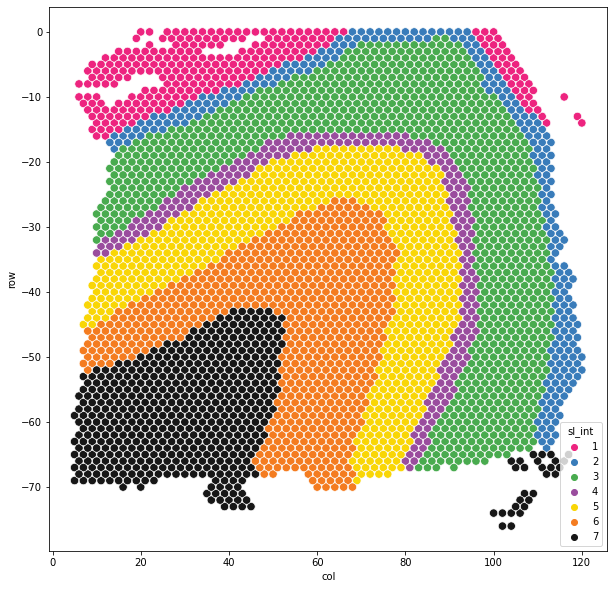

In [385]:
sl_int_map = {'L1': 1, 'L2': 2, 'L3': 3, 'L4': 4, 'L5': 5, 'L6': 6, 'WM': 7, np.nan: 7}

df = nts[151673]
df.obs['sl_int'] = df.obs['spatialLIBD'].map(sl_int_map)
sns.scatterplot(
        x=df.obs['col'], y=-1*df.obs['row'], 
        hue=df.obs['sl_int'], 
        s=70, 
        palette=palette)
plt.gcf().set_size_inches(10, 10)

In [430]:
print(len([x for x in permutations([0,1,2,3,4,5,6], r=7)]))
print('5040 total permutations to test for best overlap')
results = []
for perm in permutations([1,2,3,4,5,6, 7], r=7):
    map_ = {original: swap for original, swap in zip(df.obs['kmeans+1'], perm)}

    result = (df.obs['sl_int'] == df.obs['kmeans+1'].map(map_)).sum()
    results.append((result, perm))

5040
5040 total permutations to test for best overlap


In [431]:
print(df.obs['kmeans+1'].unique())
sorted(results, reverse=True)

[7 6 5 1 3 4 2]


[(1409, (4, 1, 7, 3, 5, 2, 6)),
 (1408, (2, 1, 7, 3, 5, 4, 6)),
 (1394, (4, 1, 7, 3, 2, 5, 6)),
 (1385, (2, 1, 7, 3, 4, 5, 6)),
 (1380, (4, 1, 7, 3, 6, 2, 5)),
 (1379, (2, 1, 7, 3, 6, 4, 5)),
 (1367, (2, 1, 7, 3, 6, 5, 4)),
 (1349, (5, 1, 7, 3, 2, 4, 6)),
 (1347, (4, 1, 7, 3, 6, 5, 2)),
 (1341, (5, 1, 7, 3, 4, 2, 6)),
 (1339, (4, 1, 7, 5, 2, 3, 6)),
 (1330, (2, 1, 7, 5, 4, 3, 6)),
 (1323, (5, 1, 7, 3, 6, 2, 4)),
 (1312, (2, 1, 7, 5, 6, 3, 4)),
 (1302, (5, 1, 7, 3, 6, 4, 2)),
 (1301, (2, 1, 7, 3, 5, 6, 4)),
 (1299, (4, 1, 7, 3, 2, 6, 5)),
 (1292, (4, 1, 7, 5, 6, 3, 2)),
 (1290, (2, 1, 7, 3, 4, 6, 5)),
 (1281, (4, 1, 7, 3, 5, 6, 2)),
 (1265, (6, 1, 7, 3, 5, 2, 4)),
 (1262, (6, 1, 7, 3, 2, 4, 5)),
 (1262, (2, 1, 7, 4, 5, 3, 6)),
 (1254, (6, 1, 7, 3, 4, 2, 5)),
 (1250, (6, 1, 7, 3, 2, 5, 4)),
 (1244, (6, 1, 7, 3, 5, 4, 2)),
 (1242, (5, 1, 7, 3, 2, 6, 4)),
 (1234, (4, 1, 7, 2, 5, 3, 6)),
 (1233, (4, 5, 7, 3, 1, 2, 6)),
 (1233, (2, 1, 7, 4, 6, 3, 5)),
 (1232, (2, 5, 7, 3, 1, 4, 6)),
 (1226, 

In [ ]:
overlap_results = []
    for perm in permutations([1,2,3,4,5,6,7], r=7):
        map_ = {original: swap for original, swap in zip(df.obs['kmeans+1'], perm)}
        result = (df.obs['sl_int'] == nts.obs['kmeans+1'].map(map_)).sum()
        overlap_results.append((result, perm)) 
    print(sorted(overlap_results, reverse=True)[0:20])

In [458]:
balanced_accuracy_score(y_true=[1,1,2,2,3,3,4,4,4,4,4,4,4,4,4,4,4], y_pred=[2,1,2,1,3,1,4,1,4,4,4,4,4,4,4,4,4])

0.6022727272727273

In [460]:
balanced_accuracy_score(df.obs['sl_int'], df.obs['kmeans+1'].map(map_))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Computing accuracy between "Ground Truth" and KMeans prediction is difficult for two reasons:
## 1. Simple accuracy unfairly weights results that favor the layer with the most spots. Use balanced accuracy
## 2. Testing every permutation of the 7 labels to check for the best balanced accuracy is time consuming, so do it all before and save result

In [546]:
def get_acc_results(acc, acc_results):
    for sample in nts:
        print(sample)
        df = nts[sample]
        df = df.obs.loc[df.obs['spatialLIBD'].notna()]
        unique_labels = df['spatialLIBD'].unique()
        unique_kmeans = df['kmeans'].unique()
        li = []
        for perm in permutations(unique_labels, r=len(unique_labels)):
#             print(perm)
            map_ = {original: swap for original, swap in zip(unique_kmeans, perm)}
#             print(map_)
            result = acc(df['spatialLIBD'], df['kmeans'].map(map_))
#             print(result)
            li.append((result, map_))
        acc_results[sample] = sorted(li, reverse=True, key=lambda x: x[0])

In [555]:
balanced_accuracy_results = {}
get_acc_results(balanced_accuracy_score, balanced_accuracy_results)

151507
151508
151669
151670
151673
151674


In [547]:
accuracy_results = {}
get_acc_results(accuracy_score, accuracy_results)

151507
151508
151669
151670
151673
151674


In [509]:
r = []
i = 0
unique_labels = df['spatialLIBD'].unique()
for perm in permutations(unique_labels, r=len(unique_labels)):
    map_ = {original: swap for original, swap in zip(unique_labels, perm)}
    #         print(map_)
    result = accuracy_score(df['spatialLIBD'], df['spatialLIBD'].map(map_))
    r.append((result, map_))
    i += 1
    if i % 100 == 0:
        print(i)
print(sorted(r, reverse=True))

100
200
300
400
500
600
700
800
900
1000
1100
1200


KeyboardInterrupt: 

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

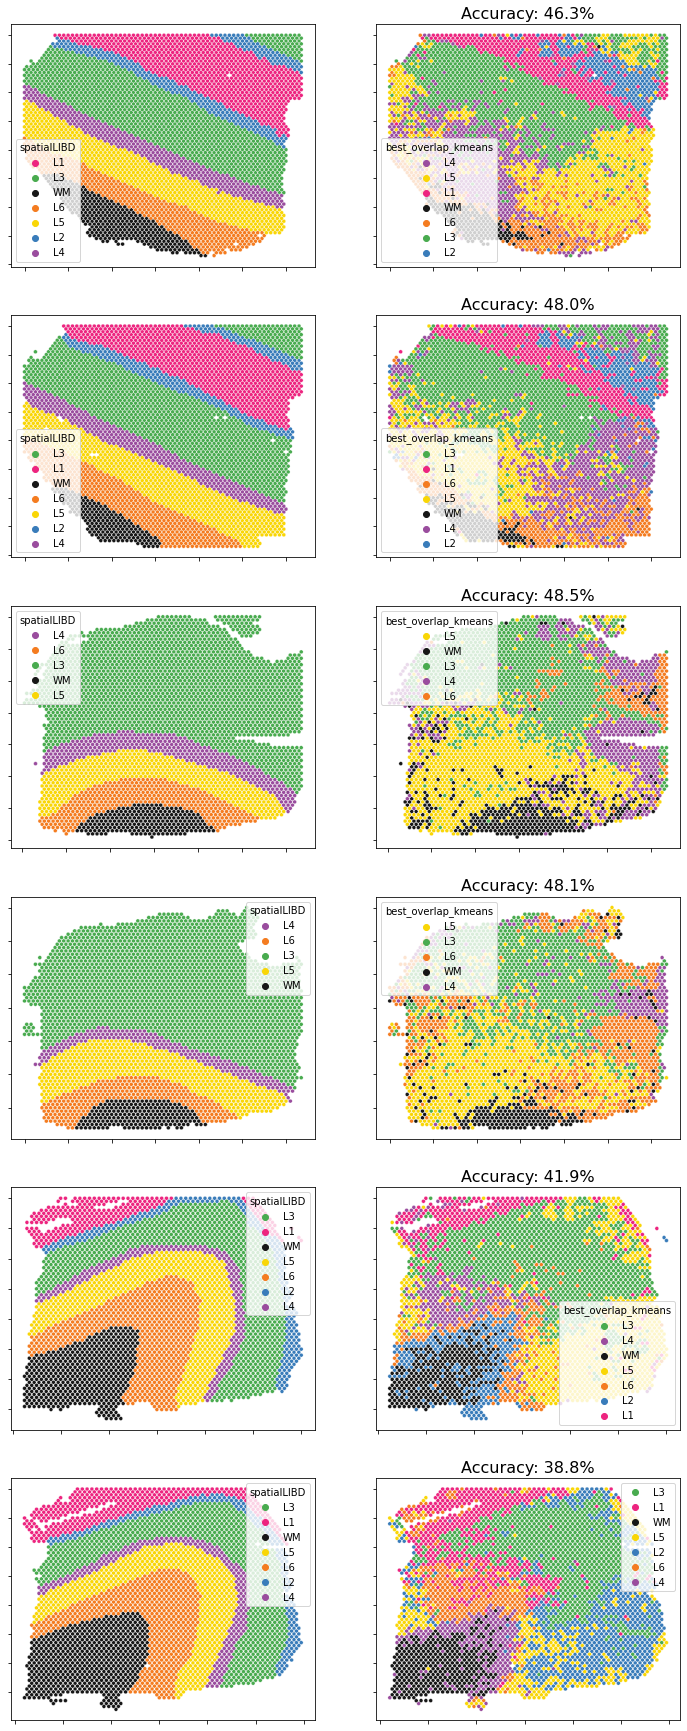

In [556]:
# sl_int_map = {'L1': 1, 'L2': 2, 'L3': 3, 'L4': 4, 'L5': 5, 'L6': 6, 'WM': 7, np.nan: 7}
nrows = 6
fig, axs = plt.subplots(nrows=nrows, ncols=2)
fig.set_size_inches(12, 3 + nrows*4.7)

for row, sample in enumerate(nts):
    if row  == nrows: 
        break
    df = nts[sample].obs.loc[nts[sample].obs['spatialLIBD'].notna()]
#     df = df.obs.loc[df.obs['spatialLIBD'].notna()]
#     df['sl_int'] = df['spatialLIBD'].map(sl_int_map)
#     df['kmeans+1'] = df['kmeans'] + 1
#     overlap_results = []
#     unique_labels = df['spatialLIBD'].unique()
#     for perm in permutations(unique_labels, r=len(unique_labels)):
#         map_ = {original: swap for original, swap in zip(df['spatialLIBD'], perm)}
#         result = balanced_accuracy_score(df['spatialLIBD'], df['spatialLIBD'].map(map_))
#         overlap_results.append((result, perm)) 
#     print(sorted(overlap_results, reverse=True)[0:20])
#     best = sorted(overlap_results, reverse=True)[0]
    best_map = accuracy_results[sample][0][1]  # accuracy or balanced_accuracy
    df['best_overlap_kmeans'] = df['kmeans'].map(best_map)
    for col, data in zip([0, 1], ['spatialLIBD', 'best_overlap_kmeans']):
        sns.scatterplot(
            x=df['col'], y=-1*df['row'], 
            hue=df[data], 
            s=15, 
            palette=palette,
            legend=True,
            ax=axs[row][col])
    df_accuracy = accuracy_results[sample][0][0] * 100
    axs[row][1].yaxis.set_label_position('right')
    axs[row][1].set_title('Accuracy: ' + str(round(df_accuracy , 1)) + '%', rotation=0, fontsize=16)
for i in range(nrows * 2):
    row, col = divmod(i, 2)
    axs[row][col].set_xlabel('')
    axs[row][col].set_ylabel('')
    axs[row][col].set_xticklabels([])
    axs[row][col].set_yticklabels([])
plt.gca().legend()

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

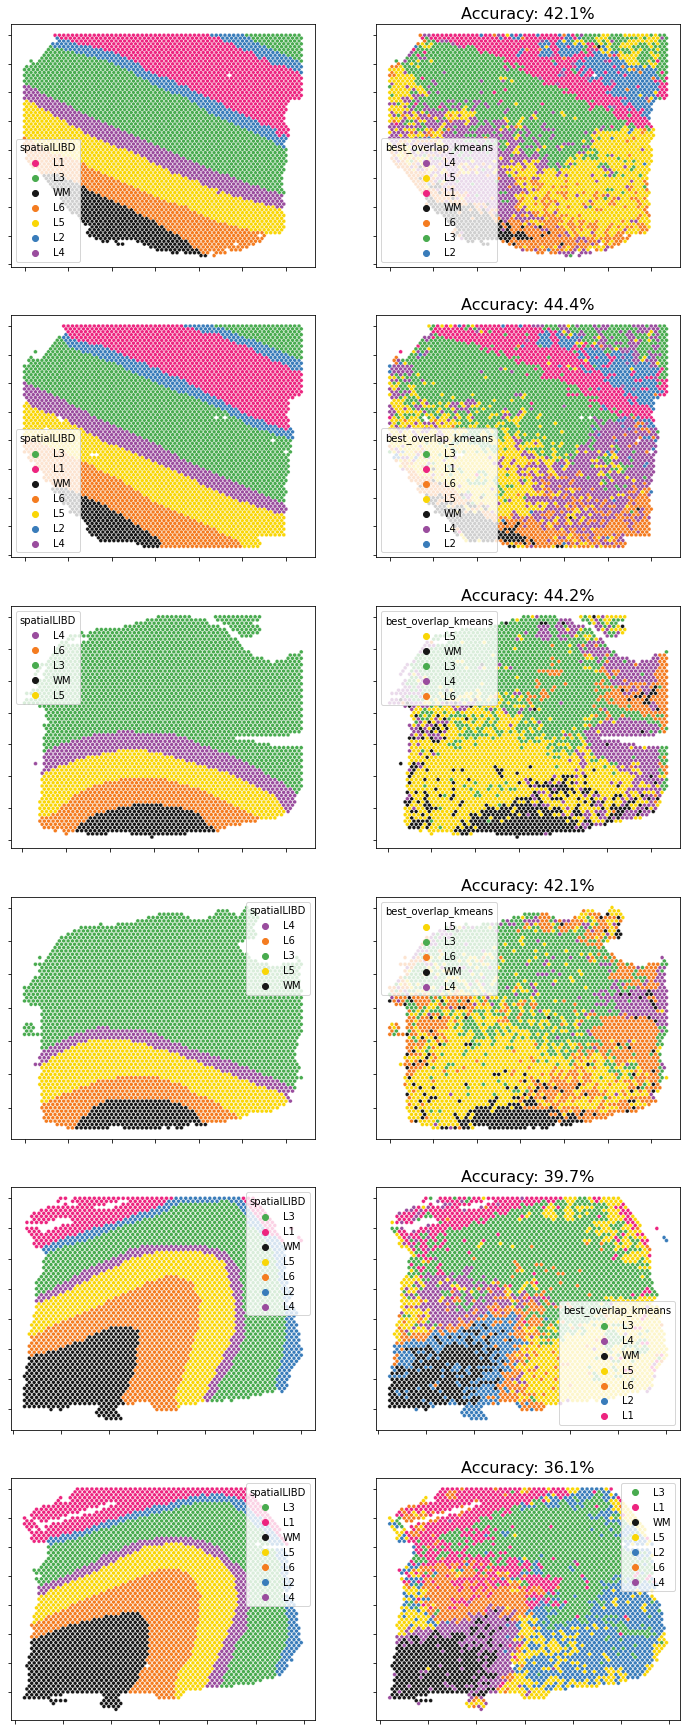

In [557]:
# sl_int_map = {'L1': 1, 'L2': 2, 'L3': 3, 'L4': 4, 'L5': 5, 'L6': 6, 'WM': 7, np.nan: 7}
nrows = 6
fig, axs = plt.subplots(nrows=nrows, ncols=2)
fig.set_size_inches(12, 3 + nrows*4.7)

for row, sample in enumerate(nts):
    if row  == nrows: 
        break
    df = nts[sample].obs.loc[nts[sample].obs['spatialLIBD'].notna()]
#     df = df.obs.loc[df.obs['spatialLIBD'].notna()]
#     df['sl_int'] = df['spatialLIBD'].map(sl_int_map)
#     df['kmeans+1'] = df['kmeans'] + 1
#     overlap_results = []
#     unique_labels = df['spatialLIBD'].unique()
#     for perm in permutations(unique_labels, r=len(unique_labels)):
#         map_ = {original: swap for original, swap in zip(df['spatialLIBD'], perm)}
#         result = balanced_accuracy_score(df['spatialLIBD'], df['spatialLIBD'].map(map_))
#         overlap_results.append((result, perm)) 
#     print(sorted(overlap_results, reverse=True)[0:20])
#     best = sorted(overlap_results, reverse=True)[0]
    best_map = accuracy_results[sample][0][1]  # accuracy or balanced_accuracy
    df['best_overlap_kmeans'] = df['kmeans'].map(best_map)
    for col, data in zip([0, 1], ['spatialLIBD', 'best_overlap_kmeans']):
        sns.scatterplot(
            x=df['col'], y=-1*df['row'], 
            hue=df[data], 
            s=15, 
            palette=palette,
            legend=True,
            ax=axs[row][col])
    df_accuracy = balanced_accuracy_results[sample][0][0] * 100
    axs[row][1].yaxis.set_label_position('right')
    axs[row][1].set_title('Accuracy: ' + str(round(df_accuracy , 1)) + '%', rotation=0, fontsize=16)
for i in range(nrows * 2):
    row, col = divmod(i, 2)
    axs[row][col].set_xlabel('')
    axs[row][col].set_ylabel('')
    axs[row][col].set_xticklabels([])
    axs[row][col].set_yticklabels([])
plt.gca().legend()

In [260]:
subset.obs.SNN_k50_k6.unique()

array([1, 4, 6, 2, 5, 3], dtype=int64)

In [ ]:
for sample in nts:
    sc.tl.some(nts[sample])

In [244]:
sc.pl.umap(nts[151507], color=['Cluster'], palette=palette)

KeyError: 151507

<Figure size 432x288 with 0 Axes>

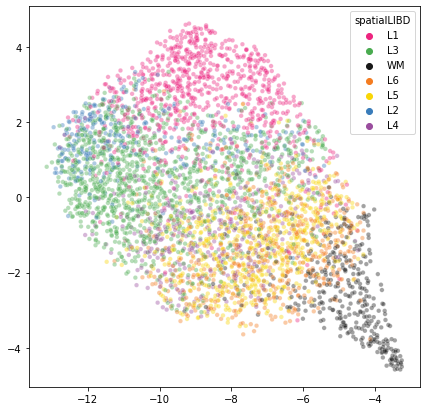

<Figure size 432x288 with 0 Axes>

In [256]:
df = d[151507]

sns.scatterplot(x=df.obsm['X_umap'][:, 0], y=df.obsm['X_umap'][:, 1], 
                hue=df.obs['spatialLIBD'], palette=palette,
                s=20, alpha=0.4)
plt.gcf().set_size_inches(7,7)
plt.figure()

In [224]:
adata.uns['spatial']

{'V1_Human_Lymph_Node': {'images': {'hires': array([[[0.5882353 , 0.6       , 0.5764706 ],
           [0.58431375, 0.6       , 0.5686275 ],
           [0.5882353 , 0.6       , 0.5686275 ],
           ...,
           [0.5803922 , 0.5921569 , 0.57254905],
           [0.5803922 , 0.59607846, 0.5764706 ],
           [0.5882353 , 0.59607846, 0.5764706 ]],
   
          [[0.5882353 , 0.6       , 0.57254905],
           [0.5882353 , 0.6       , 0.5764706 ],
           [0.58431375, 0.6       , 0.5764706 ],
           ...,
           [0.58431375, 0.59607846, 0.5803922 ],
           [0.58431375, 0.59607846, 0.5803922 ],
           [0.5882353 , 0.6       , 0.57254905]],
   
          [[0.58431375, 0.6       , 0.5803922 ],
           [0.58431375, 0.6       , 0.5764706 ],
           [0.58431375, 0.59607846, 0.57254905],
           ...,
           [0.58431375, 0.59607846, 0.5764706 ],
           [0.5803922 , 0.6       , 0.5764706 ],
           [0.58431375, 0.59607846, 0.5764706 ]],
   
          ...

In [222]:
sc.pl.spatial(d[151669], 
              img_key='../data/brain_images/151669_tissue_hires_image.png',
              )

ValueError: When .uns['spatial'][library_id] does not exist, spot_size must be provided directly.

In [235]:
samples

[151507, 151508, 151669, 151670, 151673, 151674]

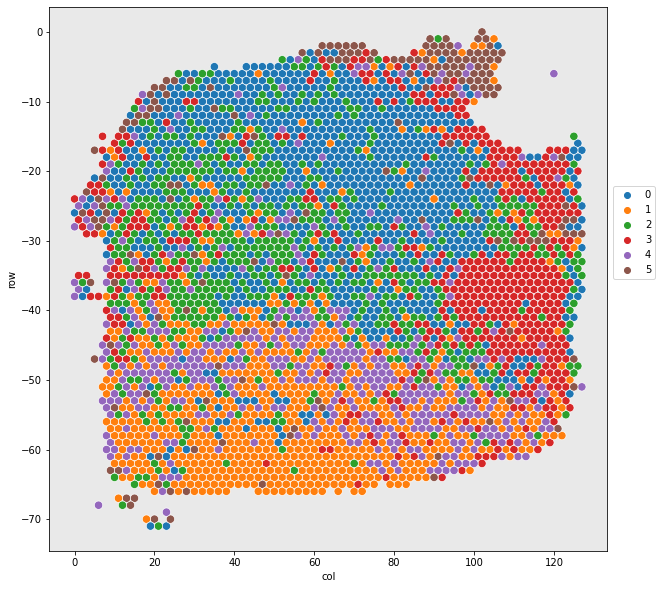

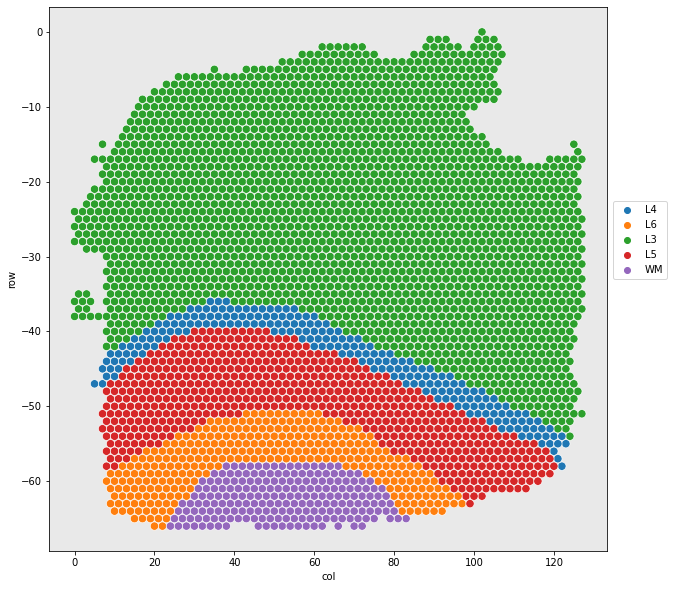

In [242]:
df = d[151670].obs

sns.scatterplot(data=df, x='col', y=-1*df.row, 
                hue=df['clusters'], s=70, 
#                 palette=palette,
               )
plt.gcf().set_size_inches(10, 10)
plt.gca().set_facecolor('#e9e9e9')
plt.legend(loc=(1.01, 0.5))

plt.figure()
sns.scatterplot(data=df, x='col', y=-1*df.row, 
                hue=df['spatialLIBD'], s=70, 
#                 palette=palette,
               )
plt.gcf().set_size_inches(10, 10)
plt.gca().set_facecolor('#e9e9e9')
plt.legend(loc=(1.01, 0.5))

In [228]:
df

barcode  sample_name  tissue  row  col  \
AAACAAGTATCTCCCA-1.4  AAACAAGTATCTCCCA-1       151669       1   50  102   
AAACACCAATAACTGC-1.4  AAACACCAATAACTGC-1       151669       1   59   19   
AAACAGAGCGACTCCT-1.3  AAACAGAGCGACTCCT-1       151669       1   14   94   
AAACAGGGTCTATATT-1.4  AAACAGGGTCTATATT-1       151669       1   47   13   
AAACATTTCCCGGATT-1.4  AAACATTTCCCGGATT-1       151669       1   61   97   
...                                  ...          ...     ...  ...  ...   
TTGTTGTGTGTCAAGA-1.4  TTGTTGTGTGTCAAGA-1       151669       1   31   77   
TTGTTTCACATCCAGG-1.4  TTGTTTCACATCCAGG-1       151669       1   58   42   
TTGTTTCATTAGTCTA-1.4  TTGTTTCATTAGTCTA-1       151669       1   60   30   
TTGTTTCCATACAACT-1.4  TTGTTTCCATACAACT-1       151669       1   45   27   
TTGTTTGTGTAAATTC-1.4  TTGTTTGTGTAAATTC-1       151669       1    7   51   

                      imagerow  imagecol  Cluster  height  width  ...  \
AAACAAGTATCTCCCA-1.4  382.7633  457.3357        2     600    600  ...   
AAACACCAATAACTGC-1.4  430.7381  200.0900        5     600    600  ...   
AAACAGAGCGACTCCT-1.3  188.6589  432.9433        3     600    600  ...   
AAACAGGGTCTATATT-1.4  366.0216  181.6382        5     600    600  ...   
AAACATTTCCCGGATT-1.4  442.0342  441.7192        3     600    600  ...   
...                        ...       ...      ...     ...    ...  ...   
TTGTTGTGTGTCAAGA-1.4  280.1530  380.1080        2     600    600  ...   
TTGTTTCACATCCAGG-1.4  425.5176  271.3321        2     600    600  ...   
TTGTTTCATTAGTCTA-1.4  436.1836  234.1584        2     600    600  ...   
TTGTTTCCATACAACT-1.4  355.3105  225.0225        4     600    600  ...   
TTGTTTGTGTAAATTC-1.4  150.6301  299.8200        3     600    600  ...   

                      pseudobulk_PCA_spatial  markers_PCA_spatial  \
AAACAAGTATCTCCCA-1.4                       1                    3   
AAACACCAATAACTGC-1.4                       3                    1   
AAACAGAGCGACTCCT-1.3                       4                    7   
AAACAGGGTCTATATT-1.4                       3                    1   
AAACATTTCCCGGATT-1.4                       3                    1   
...                                      ...                  ...   
TTGTTGTGTGTCAAGA-1.4                       1                    1   
TTGTTTCACATCCAGG-1.4                       3                    2   
TTGTTTCATTAGTCTA-1.4                       3                    5   
TTGTTTCCATACAACT-1.4                       2                    3   
TTGTTTGTGTAAATTC-1.4                       4                    7   

                     SpatialDE_UMAP_spatial  SpatialDE_pool_UMAP_spatial  \
AAACAAGTATCTCCCA-1.4                      1                            1   
AAACACCAATAACTGC-1.4                      3                            1   
AAACAGAGCGACTCCT-1.3                      2                            1   
AAACAGGGTCTATATT-1.4                      3                            4   
AAACATTTCCCGGATT-1.4                      5                            4   
...                                     ...                          ...   
TTGTTGTGTGTCAAGA-1.4                      2                            2   
TTGTTTCACATCCAGG-1.4                      5                            5   
TTGTTTCATTAGTCTA-1.4                      1                            1   
TTGTTTCCATACAACT-1.4                      1                            1   
TTGTTTGTGTAAATTC-1.4                      2                            1   

                      HVG_UMAP_spatial pseudobulk_UMAP_spatial  \
AAACAAGTATCTCCCA-1.4                 4                       1   
AAACACCAATAACTGC-1.4                 2                       4   
AAACAGAGCGACTCCT-1.3                 1                       2   
AAACAGGGTCTATATT-1.4                 2                       1   
AAACATTTCCCGGATT-1.4                 5                       4   
...                                ...                     ...   
TTGTTGTGTGTCAAGA-1.4                 5             

In [220]:
df.obs.clusters

AAACAACGAATAGTTC-1    5
AAACAAGTATCTCCCA-1    1
AAACAATCTACTAGCA-1    3
AAACACCAATAACTGC-1    2
AAACAGCTTTCAGAAG-1    2
                     ..
TTGTTGTGTGTCAAGA-1    0
TTGTTTCACATCCAGG-1    1
TTGTTTCATTAGTCTA-1    2
TTGTTTCCATACAACT-1    1
TTGTTTGTGTAAATTC-1    3
Name: clusters, Length: 4226, dtype: category
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [214]:
df.uns

OverloadedDict, wrapping:
	OrderedDict([('log1p', {'base': None}), ('hvg', {'flavor': 'seurat'}), ('pca', {'params': {'zero_center': True, 'use_highly_variable': True}, 'variance': array([3.5981312 , 3.070443  , 1.6722658 , 0.8858589 , 0.7951729 ,
       0.7016566 , 0.6755867 , 0.5947717 , 0.5574369 , 0.54690886,
       0.52068275, 0.514445  , 0.5063117 , 0.49408868, 0.48655552,
       0.4819619 , 0.4759088 , 0.47207904, 0.46519017, 0.4595387 ,
       0.4578494 , 0.4542424 , 0.44998252, 0.44456172, 0.44129714,
       0.43689594, 0.43407658, 0.43161294, 0.43085727, 0.42836916,
       0.42457935, 0.42185527, 0.42002904, 0.4155014 , 0.4132904 ,
       0.4089545 , 0.4082646 , 0.40123424, 0.4004865 , 0.39941275,
       0.39556575, 0.39118537, 0.3881523 , 0.38580453, 0.38350722,
       0.3825461 , 0.3762694 , 0.3759436 , 0.37446415, 0.37079006],
      dtype=float32), 'variance_ratio': array([0.03618856, 0.03088128, 0.01681898, 0.00890961, 0.00799753,
       0.00705698, 0.00679478, 0.00598198

In [ ]:
sc.pl.spatial(df, )

In [133]:
sc.pp.pca(normtot)
sc.pp.neighbors(normtot)
sc.tl.umap(normtot)
sc.tl.leiden(normtot, key_added='clusters')

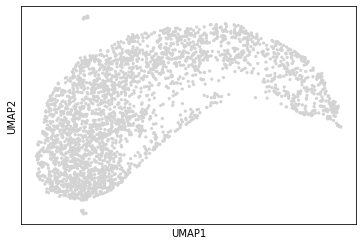

In [116]:
sc.pl.umap(normtot, color=[''])

In [55]:
test = pd.read_csv('../data/Dino_norms/151507_Dino_norm_sparse.csv', index_col=0, )
test2 = pd.read_csv('../data/Dino_norms/151508_Dino_norm_sparse.csv', index_col=0)

In [130]:
dino = None
for i, file in enumerate(Path('../data/Dino_norms').glob('*')):
    sample_name = file.stem.split('_')[0]
    if i == 0:
        dino = pd.read_csv(file, index_col=0).T
    else:
        dino = dino.append(pd.read_csv(file, index_col=0).T)
        
dino = sc.AnnData(dino.values, obs=normtot.obs, var=normtot.var)
dino

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':


AnnData object with n_obs × n_vars = 23081 × 2831
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialDE_pool_PC

In [131]:
sct = None
for i, file in enumerate(Path('../data/SCT_norms').glob('*')):
    sample_name = file.stem.split('_')[0]
    if i == 0:
        sct = pd.read_csv(file, index_col=0).T
    else:
        sct = sct.append(pd.read_csv(file, index_col=0).T)
        
sct = sc.AnnData(sct.values, obs=normtot.obs, var=normtot.var)
sct

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == '__main__':


AnnData object with n_obs × n_vars = 23081 × 2831
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialDE_pool_PC

In [206]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


#cells after MT filter: 3861


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


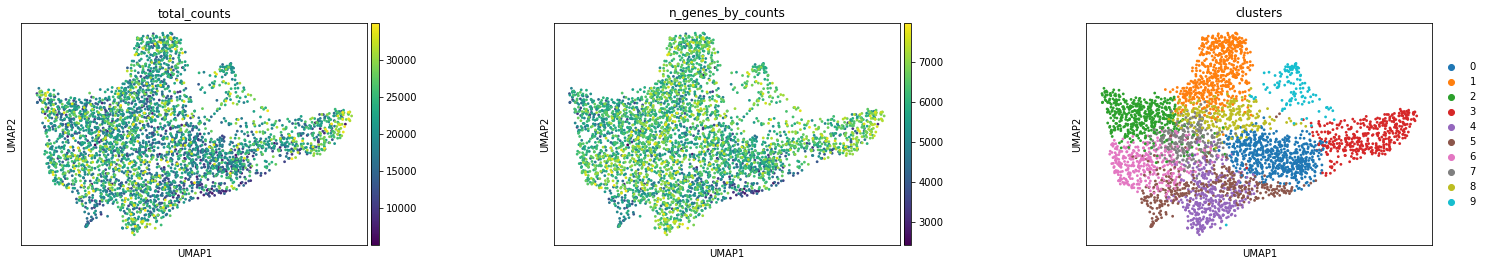

In [207]:
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)